## Synth Data (weeks & years)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
weekly_base = np.array([25,   #monday
                        80,   #tuesday
                        100,  #wednesday
                        90,   #thursday
                        60,   #friday
                        120,  #saturday
                        140]) #sunday

year_len = 52*7

In [3]:
def gen_week(weekly_base, overall_per_shift, week_var):
    new_week = weekly_base*(1+overall_per_shift)
    
    for i, day in enumerate(new_week):
        new_week[i] = day + np.random.randint(low=-week_var, high=week_var)
    return new_week
def get_hrv(stress_data, hrv_base_value, presumed_error, year=False):
    hrv_data = np.array([])
    for i, day in enumerate(stress_data):
        if i==0: 
            new_day = hrv_base_value
        else:
            day_index_2before = (i - 2) if (i - 2) >= 0 else 0
            day_index_3before = (i - 3) if (i - 3) >= 0 else 0
            day_index_4before = (i - 4) if (i - 4) >= 0 else 0
            day_index_7before = (i - 7) if (i - 7) >= 0 else 0

            stress_2day = stress_data[day_index_2before:i].copy().mean()
            stress_3day = stress_data[day_index_3before:i].copy().mean()
            stress_4day = stress_data[day_index_4before:i].copy().mean()
            stress_7day = stress_data[day_index_7before:i].copy().mean()
            
            new_day = hrv_data[i-1]
            
            mod = ((
            ((stress_7day - stress_4day) * .05) +
            ((stress_7day - stress_3day) * .10) +
            ((stress_7day - stress_2day) * .15) +
            ((stress_7day - day) * .7))*.25 
                + (np.random.randint(low=-presumed_error, high=presumed_error+1)/15.0)
            )
            new_day = new_day + mod
            
        hrv_data = np.append(hrv_data,new_day)
        if year:
            print(i) if i%10000 == 0 else 0
    return hrv_data

In [369]:
num_year_gen = 1000
stress_data = np.ndarray(shape=(num_year_gen,year_len))

for a in range(num_year_gen):
    year_data = np.array([])
    for b in range(52):
        year_data = np.append(year_data, gen_week(weekly_base = weekly_base,
                                        overall_per_shift = np.random.randint(low=-20, high=20+1)/100,
                                        week_var = 10))
    stress_data[a] = year_data

hrv_data = np.ndarray(shape=(num_year_gen,52*7))

for year in range(stress_data.shape[0]):
    hrv_data[year] = get_hrv(stress_data[year], hrv_base_value=80, presumed_error=15)

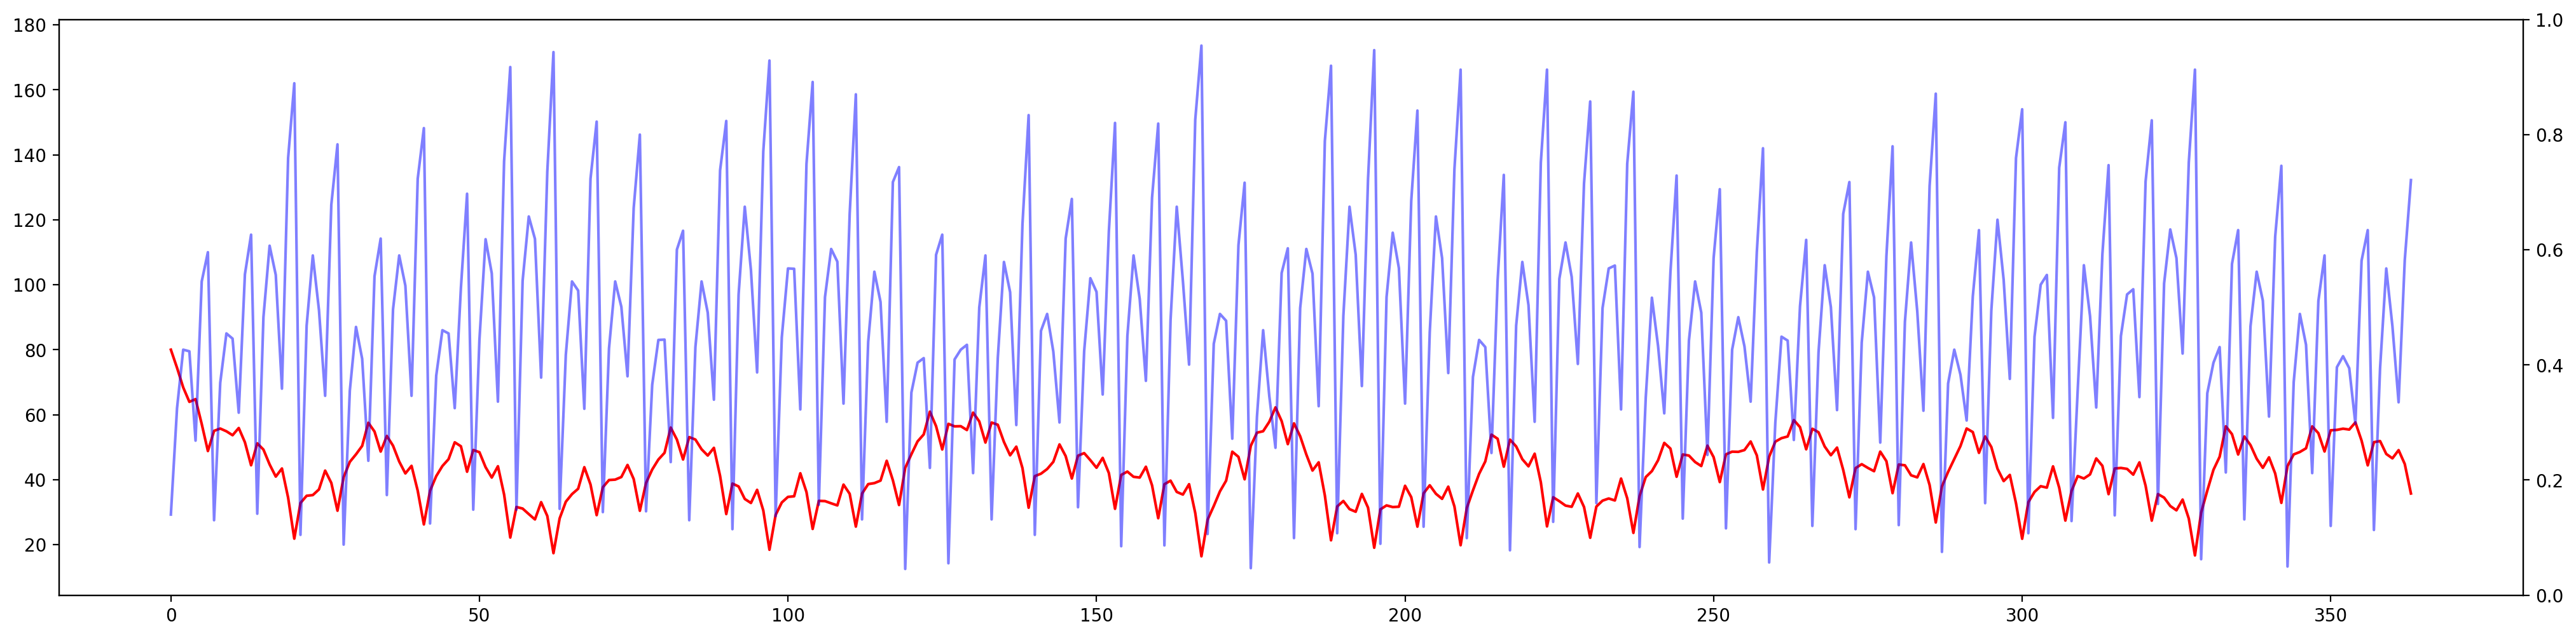

In [370]:
fig, ax = plt.subplots(figsize=(25,6), dpi=200)
ax.plot([a for a in range(year_len)], hrv_data[0], color='red')
ax1 = ax.twinx()
ax.plot([a for a in range(year_len)], stress_data[0], color='blue', alpha = .5)

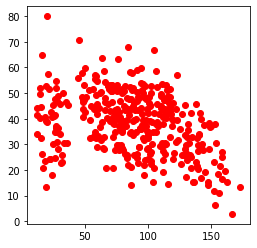

In [353]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(stress_data[0], hrv_data[0], color='red')

## Synth Data (continious)

In [8]:
num_year_gen = 100
stress_data = np.array([])

for a in range(num_year_gen):
    year_data = np.array([])
    for b in range(52):
        new_week = gen_week(weekly_base = weekly_base,
                            overall_per_shift = (np.random.randint(low=-20, 
                                                                   high=20+1)/100),
                            week_var = 10)
        year_data = np.append(year_data, new_week)
    stress_data = np.append(stress_data,year_data)
print(f'stress complete. size:{stress_data.shape[0]}')
hrv_data = np.array([])

hrv_data = get_hrv(stress_data, hrv_base_value=80, presumed_error=5)
print(f'hrv complete. size:{hrv_data.shape[0]}')

stress complete. size:36400
hrv complete. size:36400


In [9]:
def running_average_cumsum(seq, window=7):
    s = np.insert(np.cumsum(seq), 0, [0])
    return (s[window :] - s[:-window]) * (1. / window)

running_average_cumsum(hrv_data[:2000], window=7)[::40]

array([59.17340774, 51.71258503, 38.90735013, 37.32523597, 34.39899022,
       38.37083971, 39.41622874, 45.79147747, 59.10038265, 32.01977785,
       52.01788053, 42.66113308, 37.54333971, 39.55672513, 38.55764668,
       51.76707483, 49.66099702, 57.04495961, 43.92883716, 45.39171556,
       55.16179422, 38.0231909 , 51.77074405, 49.24045706, 53.02672832,
       39.36051658, 37.2025659 , 51.70914753, 60.68565264, 35.94997662,
       39.14606505, 55.37696216, 46.45878614, 41.61794855, 49.27072917,
       55.22718325, 46.69593325, 51.11871918, 60.35305485, 46.77629039,
       58.64166029, 54.97935374, 54.42876063, 40.75507866, 43.51865327,
       46.38743835, 54.06426871, 56.7014392 , 41.84597683, 48.70948767])

In [10]:
np.append([hrv_data],[stress_data], axis=0).T

array([[ 80.        ,  33.5       ],
       [ 71.26083333,  84.2       ],
       [ 62.81791667, 109.        ],
       ...,
       [135.95752976,  75.6       ],
       [131.63691964, 133.2       ],
       [121.92916667, 156.4       ]])

In [367]:
stress_data

array([7.29111856e-304, 7.29111856e-304, 7.29111856e-304, ...,
       7.18000000e+001, 1.21600000e+002, 1.45200000e+002])

## Modeling

In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [2]:
a = torch.tensor([1,5])
b = torch.tensor([5,6])

In [267]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 1)
         
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
net = NN()
print(net)

NN(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)


In [268]:
X = np.ndarray(shape=(2,year_len-1))
X[0] = stress_data[0][:-1]
X[1] = hrv_data[0][:-1]
X = torch.tensor(X.T).float()

In [275]:
y = torch.tensor(hrv_data[0][1:])

In [270]:
output = net(X)

In [274]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)

epochs = 3

In [277]:
for epoch in range(epochs):
    for data in trainset: 
        X, y = data
        net.zero_grad()
        output = net(X.view(-1, year_len - 1))
        loss = F.nll_loss(output, y)

RuntimeError: shape '[-1, 363]' is invalid for input of size 1

## Model lin

In [318]:
data_set = np.ndarray(shape=(1000,363))
for year in range(hrv_data.shape[0]):
    year_data = np.ndarray(shape=(2,year_len-1))
    year_data[0], year_data[1] = hrv_data[year][:-1], stress_data[year][:-1]
    data_set = np.append(data_set,year_data.T)
    

In [320]:
data_set.shape

(1089000,)

In [306]:
np.ndarray([hrv_data[year][:-1],hrv_data[year][:-1]])

TypeError: only integer scalar arrays can be converted to a scalar index

In [321]:
n_samples, n_features = X.shape

input_side = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
# Training Loops
num_epochs = 100
for epoch in range(epoch):
    # Forward & Loss
    y_pred = model(X)
    loss = criterion(y_pred, y)
    
    # Backward
    loss.backward()
    
    # Update
    optimizer.step() # updates the weights

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

predicted = model(X).detach().numpy()

ValueError: not enough values to unpack (expected 2, got 0)